In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import diffrax
import multi_gp
from scipy.linalg import solve_continuous_are
import time

In [2]:
_itemsize_kind_type = {
    (1, "i"): jnp.int8,
    (2, "i"): jnp.int16,
    (4, "i"): jnp.int32,
    (8, "i"): jnp.int64,
    (2, "f"): jnp.float16,
    (4, "f"): jnp.float32,
    (8, "f"): jnp.float64,
}
import jax.lax as lax

def force_bitcast_convert_type(val, new_type=jnp.int32):
    val = jnp.asarray(val)
    intermediate_type = _itemsize_kind_type[new_type.dtype.itemsize, val.dtype.kind]
    val = val.astype(intermediate_type)
    return lax.bitcast_convert_type(val, new_type)

## Environments

In [3]:
class Partial_SHO:
    def __init__(self, key, dt, omega_0, sigma, obs_noise):
        self.n_obs = 1
        self.n_var = 2
        self.omega_0 = omega_0
        self.sigma = sigma
        self.obs_noise = obs_noise
        
        self.A = jnp.array([[0,1],[-(self.omega_0**2),0]])
        self.b = jnp.array([[0.0,1.0]]).T
        self.w = self.sigma
        self.G = jnp.array([[0,0],[0,1]])
        self.W = self.sigma*self.G

        self.C = jnp.array([[1,0]])
        self.V = jnp.array([self.obs_noise])

        self.key = key
        self.dt = dt

    def f_obs(self,t,x):
        key = jrandom.fold_in(self.key, force_bitcast_convert_type(t))
        return self.C@x.T + jrandom.normal(key)*self.V

    def compute_riccati(self, objective):
        V = solve_continuous_are(self.A,self.b,objective.Q,objective.R)
        L = 1/objective.R@self.b.T@V
        return L

    def drift(self, t, x, args):
        return self.A@x + self.b@args, self.f_obs(t, x)
    
    def diffusion(self, t, x, args):
        return self.W

In [4]:
class Observable_SHO:
    def __init__(self, key, dt, omega_0, sigma):
        self.n_obs = 2
        self.n_var = 2
        self.omega_0 = omega_0
        self.sigma = sigma
        self.A = jnp.array([[0,1],[-(self.omega_0**2),0]])
        self.b = jnp.array([[0.0,1.0]]).T
        self.W = jnp.array([[0, self.sigma]]).T

        self.C = jnp.eye(2)

        self.dt = dt
        self.key = key

    def f_obs(self,t,x):
        return self.C@x

    def compute_riccati(self, objective):
        V = solve_continuous_are(self.A,self.b,objective.Q,objective.R)
        L = 1/objective.R@self.b.T@V
        return L

    def drift(self, t, x, args):
        return self.A@x + self.b@args, self.f_obs(t,x)
    
    def diffusion(self, t, x, args):
        return self.W

In [5]:
class Objective_function:
    def __init__(self, A, B):
        self.q = self.r = 0.5
        self.Q = jnp.array([[self.q,0],[0,0]])
        self.R = jnp.array([self.r])
        self.A = A
        self.B = B

    def get_rewards(self, x, u, target):
        x_d = jnp.array([target,0])
        u_d = -jnp.linalg.pinv(self.B)@self.A@x_d
        rewards = jax.vmap(lambda _x, _u: (_x-x_d).T@self.Q@(_x-x_d) + (_u-u_d)*self.R*(_u-u_d))(x,u)
        return -jnp.cumsum(rewards)

## Controllers

In [6]:
class LQG:
    def __init__(self, env, L):
        self.env = env
        self.L = L
        self.mu = jnp.array([0.0,0.0])
        self.P = jnp.eye(2)

    def drift(self, t, variables, args):
        x_star, u_star = args
        x = variables[:2]

        v = jnp.array([variables[2]])
        
        u = v + self.L@x_star + u_star[0]

        mu = variables[3:5]
        P = variables[5:]
        P = P.reshape(2,2)

        K = P@self.env.C.T*(1/self.env.V)
        dx, y = self.env.drift(t,x,u)
        dmu = self.env.A@mu + self.env.b@u + K@(y-self.env.C@mu)
        dP = self.env.A@P + P@self.env.A.T - K@self.env.C@P +self.env.G*self.env.w@self.env.G

        dv = jnp.expand_dims(-self.L@(dmu),0)
        return jnp.concatenate([dx, dv, dmu, jnp.ravel(dP)])

    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return jnp.concatenate([self.env.diffusion(t,x,args),jnp.zeros((1,2)),jnp.zeros((2,2)),jnp.zeros((4,2))])

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,-0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.VirtualBrownianTree(ts[0], ts[-1], tol=1e-3, shape=(2,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = jnp.concatenate([x0, -jnp.expand_dims(self.L@self.mu,0), self.mu, jnp.ravel(self.P)])

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star)
        )

        x = sol.ys[:,:2]
        u = sol.ys[:,2] + self.L@x_star + u_star[0]
        mu = sol.ys[:,3:5]
        P = sol.ys[:,5:]
        y = jax.vmap(self.env.f_obs)(ts, x)

        return x, y, u, mu, P

In [7]:
class LQR:
    def __init__(self, env, L):
        self.env = env
        self.L = L

    def drift(self, t, x_v, args):
        x_star, u_star = args
        x = x_v[:2]
        v = jnp.array([x_v[-1]])
        u = v + self.L@x_star + u_star
        dx, y = self.env.drift(t,x,u)
        
        dv = -jnp.expand_dims(self.L@dx,0)
        return jnp.concatenate([dx,dv])
        
    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return jnp.concatenate([self.env.diffusion(t,x,args),jnp.zeros((1,1))])

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(1,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = jnp.concatenate([x0, -jnp.expand_dims(self.L@x0,0)])

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint()
        )

        x = sol.ys[:,:2]
        u = sol.ys[:,2] + self.L@x_star + u_star
        y = jax.vmap(self.env.f_obs)(ts, x)

        return x, y, u

In [8]:
class LQR_normal:
    def __init__(self, env, L):
        self.env = env
        self.L = L

    def drift(self, t, x, args):
        u = args[1]-self.L@(x-args[0])
        dx, y = self.env.drift(t,x,u)
        return dx
        
    #apply process noise only on x
    def diffusion(self, t, variables, args):
        x = variables[:2]
        return self.env.diffusion(t,x,args)

    def solve(self, ts, x0, key, target):
        solver = diffrax.Euler()
        dt0 = 0.1
        saveat = diffrax.SaveAt(ts=ts)

        x_star = jnp.array([target,0])
        u_star = -jnp.linalg.pinv(self.env.b)@self.env.A@x_star 

        brownian_motion = diffrax.UnsafeBrownianPath(shape=(1,), key=key) #define process noise
        system = diffrax.MultiTerm(diffrax.ODETerm(self.drift), diffrax.ControlTerm(self.diffusion, brownian_motion))

        init = x0

        sol = diffrax.diffeqsolve(
            system, solver, ts[0], ts[-1], dt0, init, saveat=saveat, args=(x_star, u_star), adjoint=diffrax.DirectAdjoint()
        )

        x = sol.ys
        u = u_star-self.L@(x-x_star).T
        y = jax.vmap(self.env.f_obs)(ts, x)

        return x, y, u

In [9]:
def lqg_env(key, ts, x0, targets, dt):
    env_key, trial_key = jrandom.split(key, 2)

    omega_0 = 1.0
    sigma = 0.1
    obs_noise = 2

    env = Partial_SHO(env_key, dt, omega_0, sigma, obs_noise)

    fitness_function = Objective_function(env.A, env.b)
    L = env.compute_riccati(fitness_function)
    LQG_control = LQG(env, L)

    xs_lqg, ys_lqg, us_lqg, mu_lqg, P = jax.vmap(LQG_control.solve, in_axes=[None, 0, 0, 0])(ts, x0, jrandom.split(trial_key, 10), targets)
    rewards_lqg = jax.vmap(fitness_function.get_rewards, in_axes=[0,0,0])(xs_lqg, us_lqg, targets)

    fig, ax = plt.subplots(ncols=5,nrows=2, figsize=(15,7))
    ax = ax.ravel()
    for index in range(x0.shape[0]):
        ax[index].plot(ts,xs_lqg[index,:,0], label='$x_1$')
        ax[index].plot(ts,xs_lqg[index,:,1], label='$x_2$')
        ax[index].plot(ts,ys_lqg[index], label='y', alpha=0.5)
        ax[index].plot(ts,us_lqg[index], label='u')
    ax[-1].legend()
    plt.show()

    return env, fitness_function, rewards_lqg

In [10]:
def lqr_env(key, ts, x0, targets, dt):
    env_key, trial_key = jrandom.split(key, 2)

    omega_0 = 1.0
    sigma = 0.1

    env = Observable_SHO(key, dt, omega_0, sigma)

    fitness_function = Objective_function(env.A, env.b)
    L = env.compute_riccati(fitness_function)

    # LQR_control = LQR(env, L)
    # xs_lqr, ys_lqr, us_lqr = jax.vmap(LQR_control.solve, in_axes=[None, 0, 0, 0])(ts, x0, jrandom.split(trial_key, 10), targets)
    # rewards_lqr = jax.vmap(fitness_function.get_rewards, in_axes=[0,0,0])(ys_lqr, us_lqr, targets)

    fig, ax = plt.subplots(ncols=5,nrows=2, figsize=(15,7))
    ax = ax.ravel()
    # for index in range(x0.shape[0]):
    #     ax[index].plot(ts,xs_lqr[index,:,0], label='DE $x_1$')
    #     ax[index].plot(ts,xs_lqr[index,:,1], label='DE $x_2$')
    #     ax[index].plot(ts,us_lqr[index], label='DE u')
        
    LQR_control = LQR_normal(env, L)
    xs_lqr, ys_lqr, us_lqr = jax.vmap(LQR_control.solve, in_axes=[None, 0, 0, 0])(ts, x0, jrandom.split(trial_key, 10), targets)
    rewards_lqr = jax.vmap(fitness_function.get_rewards, in_axes=[0,0,0])(ys_lqr, us_lqr, targets)

    for index in range(x0.shape[0]):
        ax[index].plot(ts,xs_lqr[index,:,0], label='$x_1$')
        ax[index].plot(ts,xs_lqr[index,:,1], label='$x_2$')
        ax[index].plot(ts,us_lqr[index], label='u')

    ax[-1].legend()
    plt.show()

    return env, fitness_function, rewards_lqr

## GP

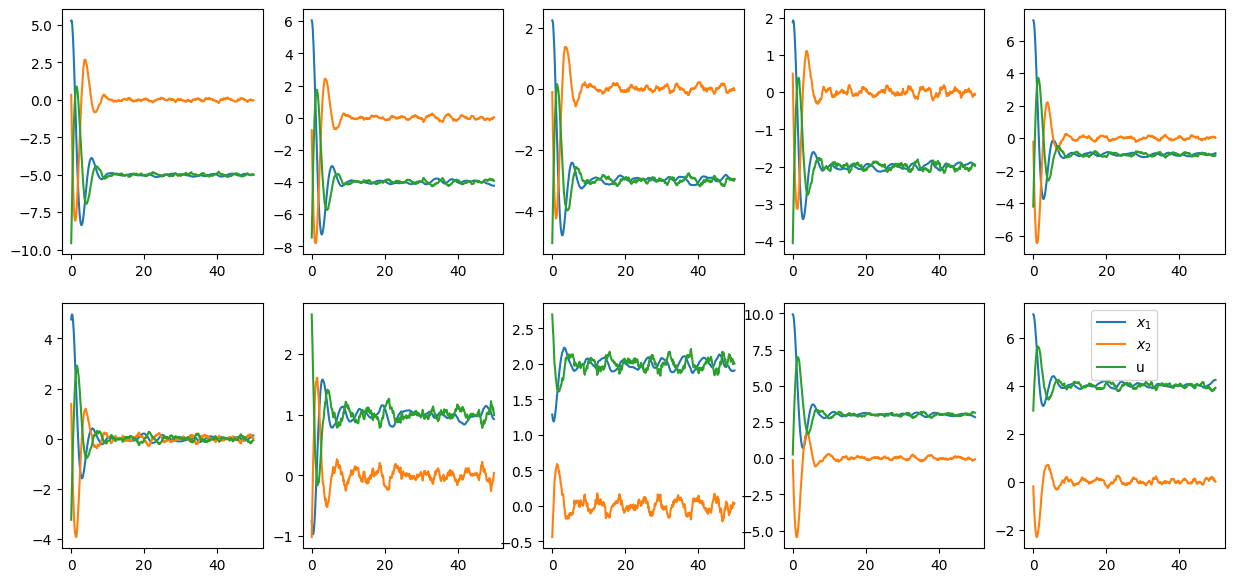

In [11]:
string = 'LQR'
seed = 1
key = jrandom.PRNGKey(seed)
key, init_key = jrandom.split(key, 2)
x0 = jrandom.normal(init_key, shape=(10,2))*jnp.array([5,1])
targets = jnp.arange(-5,5,1)
T = 50
dt = 0.1
ts = jnp.arange(0,T,dt)

if string == 'LQR':
    env, fitness_function, rewards_lq = lqr_env(key, ts, x0, targets, dt)
else:
    env, fitness_function, rewards_lq = lqg_env(key, ts, x0, targets, dt)

gp = multi_gp.ODE_GP(seed, env, fitness_function.get_rewards, 3, 1, population_size=50, num_populations=4, migration_period=5)

In [12]:
n_trials = 1
generations = 50
converge_value=jnp.mean(rewards_lq[:,-1], axis=0)*dt*-1.1
print("Optimal cost: ", converge_value)
best_fitnesses, best_solutions, final_population = gp.run((x0,ts,targets), n_trials, generations, 10, converge_value=converge_value)
for i in range(n_trials):
    plt.plot(-1*best_fitnesses[i], color="blue")
plt.hlines(jnp.mean(rewards_lq[:,-1], axis=0)*dt, 0, generations-1, color="red", label=string)
plt.plot(0, 0, label=f"GP", color="blue")
plt.title("Best fitness per generation")
plt.xlabel("Generation")
plt.ylabel("Reward")
plt.legend()
plt.show()

Optimal cost:  33.828896
In generation 0, average fitness: 61908.35546875, best_fitness: 528.765380859375


KeyboardInterrupt: 

['target+((target+((target-(x1+a0))-(x1+a0)))-(x1+a0))', '0.15799998', 'x0']
-33.99126


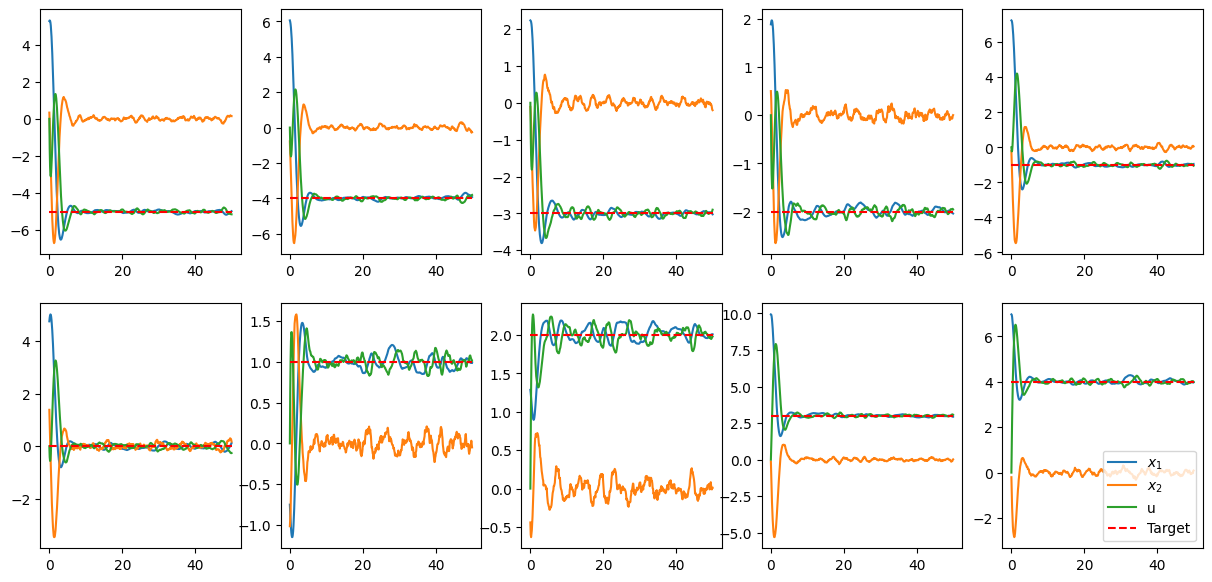

In [ ]:
# sol = multi_gp.Expression([['/',['+',[jnp.array(2.8502984+2.8502984-4.716474-1.0577378)],['+',['*',[jnp.array(-3)],['x1']],['-',['*',[jnp.array(4)],['target']],['*',[jnp.array(4.0)],['a0']]]]],[jnp.array(0.6501584)]],['a0'],['a0']])
# print(sol)
# ys_gp, us_gp, act = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0])(sol, x0, ts, targets, jrandom.split(key, x0.shape[0]))
index = 0
print(best_solutions[index])
ys_gp, us_gp, act = jax.vmap(gp.evaluate_control_loop, in_axes=[None,0,None, 0, 0])(best_solutions[index], x0, ts, targets, jrandom.split(key, x0.shape[0]))
rewards_gp = jax.vmap(fitness_function.get_rewards)(ys_gp, us_gp, targets)
print(jnp.mean(rewards_gp,axis=0)[-1]*dt)
fig, ax = plt.subplots(ncols=5,nrows=2, figsize=(15,7))
ax = ax.ravel()
for index in range(x0.shape[0]):
    ax[index].plot(ts,ys_gp[index,:,0], label='$x_1$')
    ax[index].plot(ts,ys_gp[index,:,1], label='$x_2$')
    ax[index].plot(ts,us_gp[index], label='u')
    ax[index].hlines(targets[index], ts[0], ts[-1], color="red", linestyle="--", label="Target")
ax[-1].legend()
plt.show()

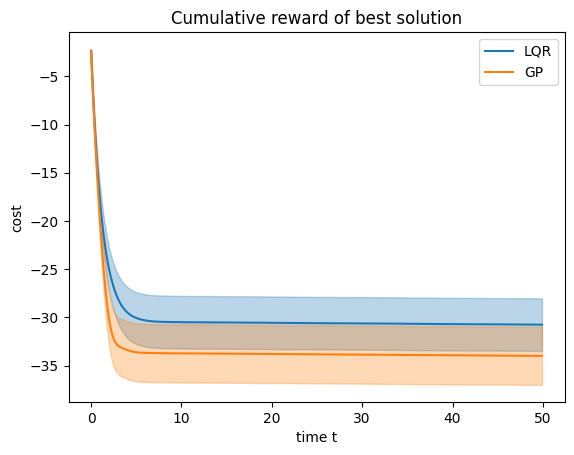

In [ ]:
mean_rewards_lq = jnp.mean(rewards_lq*dt, axis=0)
std_rewards_lq = jnp.std(rewards_lq*dt, axis=0)*dt

plt.plot(ts, mean_rewards_lq, label=string, color=f'C0')
plt.fill_between(ts, mean_rewards_lq-std_rewards_lq,  mean_rewards_lq+std_rewards_lq, color='C0', alpha=0.3)

mean_rewards_gp = jnp.mean(rewards_gp*dt, axis=0)
std_rewards_gp = jnp.std(rewards_gp*dt, axis=0)*dt

plt.plot(ts, mean_rewards_gp, label=f'GP', alpha=1., color=f'C1')
plt.fill_between(ts, mean_rewards_gp-std_rewards_gp,  mean_rewards_gp+std_rewards_gp, color='C1', alpha=0.3)

plt.xlabel('time t')
plt.ylabel('cost')
plt.title('Cumulative reward of best solution')
plt.legend()
plt.show()